# Long Short-Term Memory

## Initialization

### Import Libraries

In [1]:
# Core Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# TensorFlow / Keras Layers
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks

# Label preprocessing
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

from sklearn.metrics import f1_score

### Import Data

In [2]:
df_train = pd.read_csv('../dataset/train.csv', sep=',')
df_val = pd.read_csv('../dataset/valid.csv', sep=',')
df_test = pd.read_csv('../dataset/test.csv', sep=',')

In [3]:
label_mapping = {
    'negative': 0,
    'neutral': 1,
    'positive': 2
}

for df in [df_train, df_val, df_test]:
    df['label_id'] = df['label'].map(label_mapping)

    if df['label_id'].isnull().any():
        print("Warning: Some labels were not mapped! Check unique labels and label_mapping.")
        print(df[df['label_id'].isnull()])

x_train = np.array(df_train['text'])
y_train = np.array(df_train['label_id'])

x_val = np.array(df_val['text'])
y_val = np.array(df_val['label_id'])

x_test = np.array(df_test['text'])
y_test = np.array(df_test['label_id'])

In [4]:
print(f"x_train shape: {x_train.shape}, y_train shape: {y_train.shape}")
print(f"x_val shape: {x_val.shape}, y_val shape: {y_val.shape}")
print(f"x_test shape: {x_test.shape}, y_test shape: {y_test.shape}")

x_train shape: (500,), y_train shape: (500,)
x_val shape: (100,), y_val shape: (100,)
x_test shape: (400,), y_test shape: (400,)


## Preprocessing

Tokenized lengths: [16, 22, 6, 57, 5, 8, 6, 23, 8, 32, 77, 16, 43, 25, 47, 31, 19, 17, 9, 43, 23, 12, 37, 17, 12, 42, 12, 11, 37, 43, 7, 10, 24, 22, 13, 20, 15, 43, 28, 17, 43, 52, 36, 17, 8, 19, 28, 22, 22, 24, 7, 5, 15, 29, 15, 56, 27, 42, 11, 18, 36, 15, 19, 58, 7, 16, 7, 6, 8, 13, 15, 26, 20, 35, 6, 15, 27, 18, 47, 34, 24, 15, 41, 13, 10, 36, 15, 8, 20, 29, 23, 27, 35, 19, 33, 18, 40, 7, 33, 22, 17, 7, 18, 43, 20, 7, 49, 11, 63, 10, 11, 32, 18, 13, 46, 27, 29, 21, 42, 32, 21, 24, 49, 10, 56, 32, 30, 14, 16, 17, 19, 13, 40, 10, 9, 31, 14, 66, 23, 8, 33, 12, 26, 54, 18, 40, 30, 24, 7, 38, 57, 23, 24, 10, 19, 10, 21, 23, 18, 13, 17, 8, 58, 11, 27, 16, 13, 10, 43, 13, 30, 34, 23, 33, 6, 7, 22, 49, 7, 9, 6, 19, 41, 16, 38, 18, 14, 20, 17, 19, 28, 9, 31, 16, 27, 11, 54, 20, 50, 9, 9, 49, 9, 12, 20, 18, 46, 39, 15, 24, 24, 45, 13, 55, 11, 7, 7, 55, 41, 48, 30, 48, 24, 22, 59, 31, 23, 29, 54, 61, 29, 24, 56, 60, 6, 40, 41, 28, 8, 57, 16, 10, 19, 22, 22, 20, 28, 9, 55, 9, 19, 9, 50, 16, 9, 

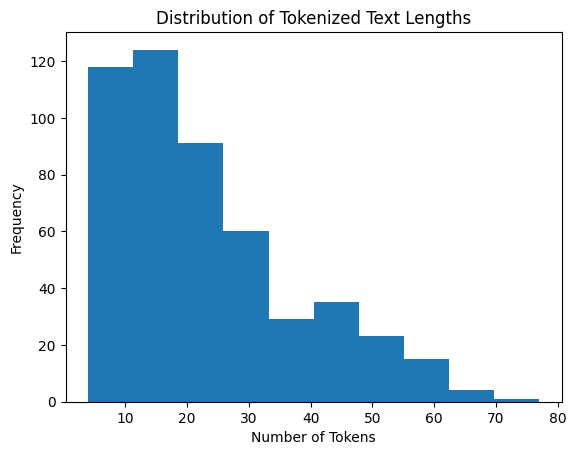

In [5]:
temp_vectorizer = layers.TextVectorization(
    standardize="lower_and_strip_punctuation",
    split="whitespace",
    output_mode="int"
)
temp_vectorizer.adapt(tf.data.Dataset.from_tensor_slices(x_train))

tokenized_lengths = []
for text in x_train:
    tokens = temp_vectorizer([text]).numpy()[0]
    tokenized_lengths.append(np.count_nonzero(tokens))

print("Tokenized lengths:", tokenized_lengths)
print("Mean length:", np.mean(tokenized_lengths))
print("Median length:", np.median(tokenized_lengths))
print("Max length:", np.max(tokenized_lengths))
print("90th percentile:", np.percentile(tokenized_lengths, 90))
print("95th percentile:", np.percentile(tokenized_lengths, 95))

plt.hist(tokenized_lengths, bins=10)
plt.title('Distribution of Tokenized Text Lengths')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
plt.show()

In [6]:
vectorize_layer_full_vocab = layers.TextVectorization(
    max_tokens=None,
    standardize="lower_and_strip_punctuation",
    split="whitespace",
    output_mode="int"
)

vectorize_layer_full_vocab.adapt(tf.data.Dataset.from_tensor_slices(x_train))

full_vocabulary = vectorize_layer_full_vocab.get_vocabulary()

print(f"Total unique tokens (including OOV if present): {len(full_vocabulary)}")
print("Top 20 most frequent tokens:", full_vocabulary[:20])
print("Some of the least frequent tokens:", full_vocabulary[-20:])

Total unique tokens (including OOV if present): 2836
Top 20 most frequent tokens: ['', '[UNK]', np.str_('yang'), np.str_('di'), np.str_('dan'), np.str_('tidak'), np.str_('saya'), np.str_('dengan'), np.str_('enak'), np.str_('ini'), np.str_('makan'), np.str_('untuk'), np.str_('ke'), np.str_('tempat'), np.str_('makanan'), np.str_('juga'), np.str_('sangat'), np.str_('ada'), np.str_('banyak'), np.str_('karena')]
Some of the least frequent tokens: [np.str_('360'), np.str_('2x'), np.str_('2baso'), np.str_('2910'), np.str_('270'), np.str_('25000'), np.str_('250'), np.str_('2012'), np.str_('2002'), np.str_('1996'), np.str_('190000'), np.str_('18'), np.str_('1748'), np.str_('16'), np.str_('15000'), np.str_('150'), np.str_('14000'), np.str_('120'), np.str_('12'), np.str_('1000')]


### Preprocessing Result
Since the number of unique tokens is not significantly large, we will use (2836+1) **2837 as the vocabulary size** (max_tokens) and take the 95th percentile value of **54 as the output_sequence_length**

In [7]:
MAX_TOKENS = 2837
OUTPUT_SEQUENCE_LENGTH = 54
EMBEDDING_DIM = 64
NUM_CLASSES = 3

MODEL_SAVE_DIR = '../bin/lstm_models'
PLOT_SAVE_DIR = '../bin/lstm_plots'

In [8]:
os.makedirs(MODEL_SAVE_DIR, exist_ok=True)
os.makedirs(PLOT_SAVE_DIR, exist_ok=True)

In [9]:
text_vectorization_layer = layers.TextVectorization(
    max_tokens=MAX_TOKENS,
    standardize="lower_and_strip_punctuation",
    split="whitespace",
    output_mode="int",
    output_sequence_length=OUTPUT_SEQUENCE_LENGTH
)

text_vectorization_layer.adapt(tf.data.Dataset.from_tensor_slices(x_train))

## Training and Prediction

### Boilerplate Functions

In [10]:
def calculate_macro_f1(y_true, y_pred_classes):
    return f1_score(y_true, y_pred_classes, average='macro')

def plot_training_history(history, title, filename):
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{title} - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{title} - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)


    plt.tight_layout()
    plt.savefig(os.path.join(PLOT_SAVE_DIR, filename))
    plt.show()
    plt.close()

In [11]:
def build_lstm_model(num_lstm_layers=1, lstm_units=64, lstm_direction='unidirectional', num_classes=NUM_CLASSES):
    model = models.Sequential()

    model.add(layers.Input(shape=(1,), dtype=tf.string))
    model.add(text_vectorization_layer)
    model.add(layers.Embedding(
        input_dim=MAX_TOKENS,
        output_dim=EMBEDDING_DIM
    ))

    for i in range(num_lstm_layers):
        return_sequences = (i < num_lstm_layers - 1)

        if lstm_direction == 'unidirectional':
            model.add(layers.LSTM(lstm_units, return_sequences=return_sequences))
        elif lstm_direction == 'bidirectional':
            model.add(layers.Bidirectional(layers.LSTM(lstm_units, return_sequences=return_sequences)))
        else:
            raise ValueError("lstm_direction must be 'unidirectional' or 'bidirectional'")

        model.add(layers.Dropout(0.3))

    model.add(layers.Dense(num_classes, activation='softmax'))

    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

In [12]:
def train_and_evaluate_model(model_name, model_params, x_train, y_train, x_val, y_val, epochs=10, batch_size=32):
    print(f"\n--- Training Model: {model_name} ---")
    model = build_lstm_model(**model_params)
    model.summary()

    # Define callbacks
    os.makedirs(MODEL_SAVE_DIR, exist_ok=True) # Ensure directory exists
    model_filepath = os.path.join(MODEL_SAVE_DIR, f'{model_name}_best.h5') # Use .h5 for full model

    checkpoint_callback = callbacks.ModelCheckpoint(
        filepath=model_filepath,
        save_weights_only=False,  # MUST BE False to create 'model_weights' group
        monitor='val_loss',
        mode='min',
        save_best_only=True,
        verbose=0
    )
    early_stopping_callback = callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=False, # CHANGED: Set to False
        verbose=0
    )

    history = model.fit(
        x_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_val, y_val),
        callbacks=[checkpoint_callback, early_stopping_callback],
        verbose=1
    )

    plot_title = f"{model_name}"
    # You'll need to ensure plot_filename includes a valid path or that MODEL_SAVE_DIR is appropriate
    plot_filename_path = f"{model_name}_loss_accuracy.png"
    plot_training_history(history, plot_title, plot_filename_path)

    print(f"Best Keras model (full) saved to: {model_filepath}") # This file is ready for your Sequential class

    # These predictions will be based on the model state at the end of fit()
    y_val_pred_probs = model.predict(x_val)
    y_val_pred_classes = np.argmax(y_val_pred_probs, axis=1)

    y_test_pred_probs = model.predict(x_test)
    y_test_pred_classes = np.argmax(y_test_pred_probs, axis=1)

    return history, y_val_pred_classes, y_test_pred_classes

In [13]:
def evaluate_macro_f1(y_true, y_pred, dataset_name="Validation"):
    """
    Calculates and prints the macro F1-score.
    """
    macro_f1 = f1_score(y_true, y_pred, average='macro')
    print(f"Macro F1-score on {dataset_name} set: {macro_f1:.4f}")
    return macro_f1

### Variation in Number of LSTM Layers


--- Training Model: LSTM_Layers_1 ---


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization_2            │ (None, 54)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 54, 64)         │       181,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 214,787 (839.01 KB)

 Trainable params: 214,787 (839.01 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.4051 - loss: 1.0896

16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 170ms/step - accuracy: 0.4041 - loss: 1.0896 - val_accuracy: 0.3800 - val_loss: 1.0819
Epoch 2/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.3870 - loss: 1.0830

16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - accuracy: 0.3880 - loss: 1.0830 - val_accuracy: 0.3800 - val_loss: 1.0816
Epoch 3/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.3984 - loss: 1.0797

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - accuracy: 0.3983 - loss: 1.0797 - val_accuracy: 0.3800 - val_loss: 1.0794
Epoch 4/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.4132 - loss: 1.0834

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - accuracy: 0.4144 - loss: 1.0830 - val_accuracy: 0.5000 - val_loss: 1.0616
Epoch 5/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.4901 - loss: 0.9814

16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step - accuracy: 0.4911 - loss: 0.9787 - val_accuracy: 0.5300 - val_loss: 0.8942
Epoch 6/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - accuracy: 0.6233 - loss: 0.7672 - val_accuracy: 0.5800 - val_loss: 0.9315
Epoch 7/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - accuracy: 0.6890 - loss: 0.7242 - val_accuracy: 0.5000 - val_loss: 1.0356
Epoch 8/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - accuracy: 0.6406 - loss: 0.7869 - val_accuracy: 0.5700 - val_loss: 0.9507
Epoch 9/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - accuracy: 0.6934 - loss: 0.6801 - val_accuracy: 0.5600 - val_loss: 0.9670
Epoch 10/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - accuracy: 0.6883 - loss: 0.6658 - val_accuracy: 0.5800 - val_loss: 0.9705


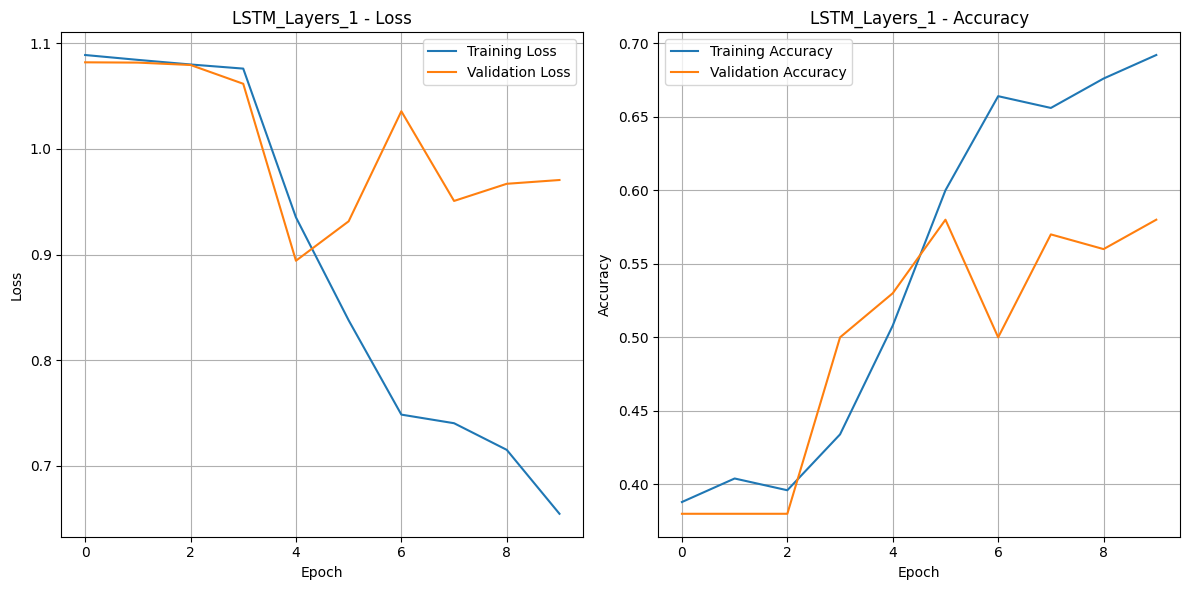

Best Keras model (full) saved to: ../bin/lstm_models\LSTM_Layers_1_best.h5
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 229ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Macro F1-score on Validation set: 0.4472
Macro F1-score on Test set: 0.4881

--- Training Model: LSTM_Layers_2 ---


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization_2            │ (None, 54)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_1 (Embedding)         │ (None, 54, 64)         │       181,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 54, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 54, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 247,811 (968.01 KB)

 Trainable params: 247,811 (968.01 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.3260 - loss: 1.0974

16/16 ━━━━━━━━━━━━━━━━━━━━ 11s 139ms/step - accuracy: 0.3285 - loss: 1.0968 - val_accuracy: 0.4500 - val_loss: 1.0820
Epoch 2/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.4327 - loss: 1.0763

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - accuracy: 0.4308 - loss: 1.0769 - val_accuracy: 0.5000 - val_loss: 1.0704
Epoch 3/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.4612 - loss: 1.0377

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - accuracy: 0.4625 - loss: 1.0352 - val_accuracy: 0.4700 - val_loss: 1.0102
Epoch 4/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.5495 - loss: 0.9020

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - accuracy: 0.5523 - loss: 0.8973 - val_accuracy: 0.5400 - val_loss: 0.9121
Epoch 5/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.6646 - loss: 0.6419

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - accuracy: 0.6644 - loss: 0.6431 - val_accuracy: 0.6400 - val_loss: 0.8494
Epoch 6/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - accuracy: 0.7078 - loss: 0.5697 - val_accuracy: 0.6200 - val_loss: 0.9090
Epoch 7/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 0.7877 - loss: 0.4703 - val_accuracy: 0.5700 - val_loss: 1.1108
Epoch 8/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 0.7247 - loss: 0.5425 - val_accuracy: 0.6300 - val_loss: 1.0098
Epoch 9/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 0.9367 - loss: 0.2889 - val_accuracy: 0.5900 - val_loss: 1.4016
Epoch 10/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - accuracy: 0.9085 - loss: 0.3219 - val_accuracy: 0.7000 - val_loss: 0.9671


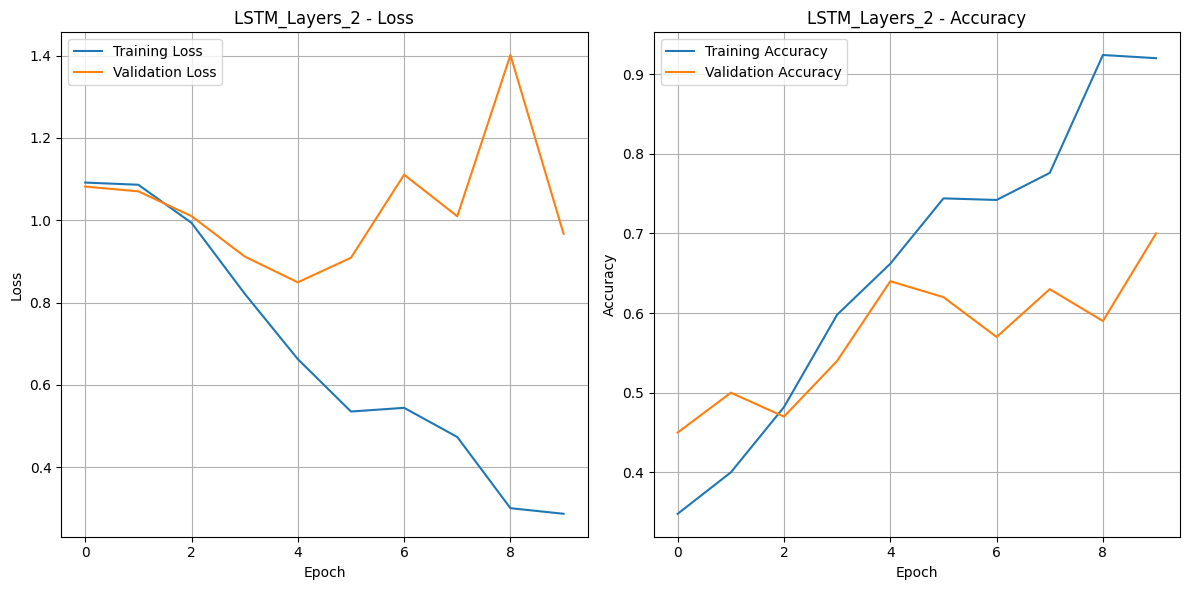

Best Keras model (full) saved to: ../bin/lstm_models\LSTM_Layers_2_best.h5
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 217ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Macro F1-score on Validation set: 0.6939
Macro F1-score on Test set: 0.6437

--- Training Model: LSTM_Layers_3 ---


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization_2            │ (None, 54)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_2 (Embedding)         │ (None, 54, 64)         │       181,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 54, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 54, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 54, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 54, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 280,835 (1.07 MB)

 Trainable params: 280,835 (1.07 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.3558 - loss: 1.0927

16/16 ━━━━━━━━━━━━━━━━━━━━ 10s 179ms/step - accuracy: 0.3565 - loss: 1.0925 - val_accuracy: 0.4600 - val_loss: 1.0761
Epoch 2/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.4295 - loss: 1.0601

16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - accuracy: 0.4307 - loss: 1.0587 - val_accuracy: 0.4500 - val_loss: 1.0454
Epoch 3/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.4579 - loss: 0.9772

16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step - accuracy: 0.4612 - loss: 0.9746 - val_accuracy: 0.5700 - val_loss: 0.9218
Epoch 4/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.6094 - loss: 0.8265

16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step - accuracy: 0.6129 - loss: 0.8201 - val_accuracy: 0.5900 - val_loss: 0.8982
Epoch 5/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 108ms/step - accuracy: 0.7499 - loss: 0.5563 - val_accuracy: 0.6500 - val_loss: 0.9454
Epoch 6/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 108ms/step - accuracy: 0.9005 - loss: 0.3511 - val_accuracy: 0.6400 - val_loss: 1.1059
Epoch 7/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 109ms/step - accuracy: 0.9288 - loss: 0.2600 - val_accuracy: 0.6000 - val_loss: 1.0855
Epoch 8/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step - accuracy: 0.9251 - loss: 0.2481 - val_accuracy: 0.6300 - val_loss: 1.1947
Epoch 9/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step - accuracy: 0.9684 - loss: 0.1308 - val_accuracy: 0.6400 - val_loss: 1.3934


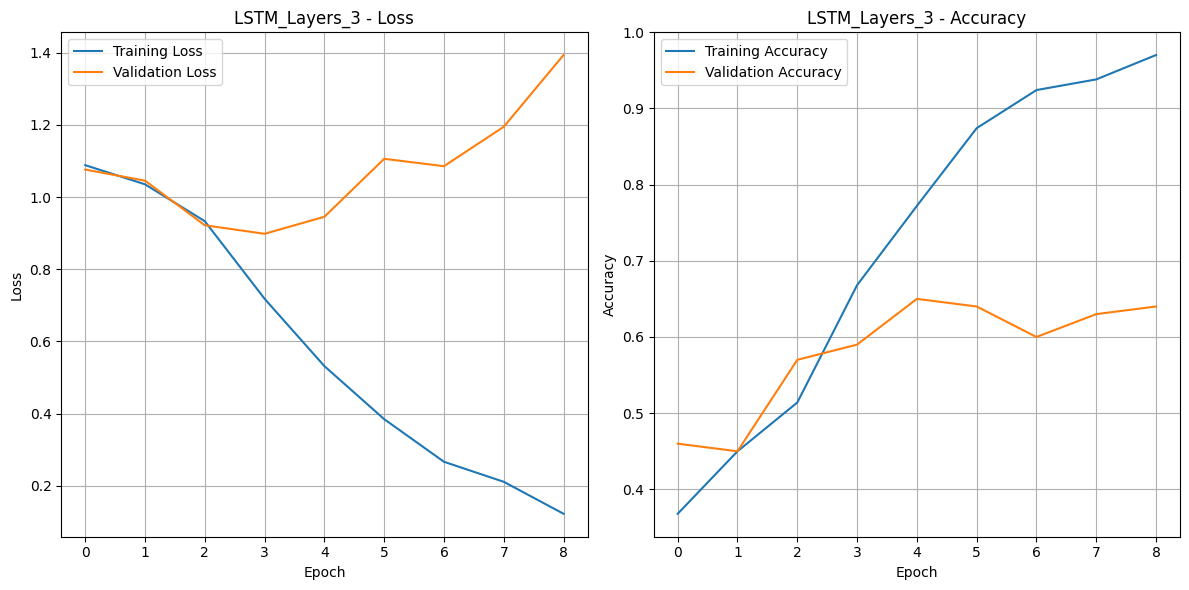

Best Keras model (full) saved to: ../bin/lstm_models\LSTM_Layers_3_best.h5
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 301ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step
Macro F1-score on Validation set: 0.6346
Macro F1-score on Test set: 0.6691

--- Summary: Pengaruh jumlah layer LSTM ---
LSTM_Layers_1: Validation Macro F1 = 0.4472, Test Macro F1 = 0.4881
LSTM_Layers_2: Validation Macro F1 = 0.6939, Test Macro F1 = 0.6437
LSTM_Layers_3: Validation Macro F1 = 0.6346, Test Macro F1 = 0.6691


In [14]:
lstm_layer_variations = [1, 2, 3]

results_layer_count = {}

for num_layers in lstm_layer_variations:
    model_params = {
        'num_lstm_layers': num_layers,
        'lstm_units': 64,
        'lstm_direction': 'unidirectional'
    }
    model_name = f"LSTM_Layers_{num_layers}"

    history, y_val_pred, y_test_pred = train_and_evaluate_model(
        model_name,
        model_params,
        x_train, y_train, x_val, y_val,
        epochs=15
    )

    val_macro_f1 = evaluate_macro_f1(y_val, y_val_pred, "Validation")
    test_macro_f1 = evaluate_macro_f1(y_test, y_test_pred, "Test")

    results_layer_count[model_name] = {
        'val_macro_f1': val_macro_f1,
        'test_macro_f1': test_macro_f1,
        'history': history
    }

print("\n--- Summary: Pengaruh jumlah layer LSTM ---")
for name, res in results_layer_count.items():
    print(f"{name}: Validation Macro F1 = {res['val_macro_f1']:.4f}, Test Macro F1 = {res['test_macro_f1']:.4f}")


### Variation in Number of LSTM Cells


--- Training Model: LSTM_Units_32 ---


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization_2            │ (None, 54)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_3 (Embedding)         │ (None, 54, 64)         │       181,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 54, 32)         │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 54, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 32)             │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 202,403 (790.64 KB)

 Trainable params: 202,403 (790.64 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.3669 - loss: 1.0965

16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 121ms/step - accuracy: 0.3683 - loss: 1.0962 - val_accuracy: 0.3800 - val_loss: 1.0841
Epoch 2/15
15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.3851 - loss: 1.0872

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 0.3845 - loss: 1.0866 - val_accuracy: 0.3800 - val_loss: 1.0813
Epoch 3/15
15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.4271 - loss: 1.0754

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 0.4260 - loss: 1.0757 - val_accuracy: 0.3700 - val_loss: 1.0729
Epoch 4/15
15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.4562 - loss: 1.0575

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.4540 - loss: 1.0572 - val_accuracy: 0.4900 - val_loss: 1.0170
Epoch 5/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 0.5255 - loss: 0.9629 - val_accuracy: 0.4200 - val_loss: 1.2064
Epoch 6/15
15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.6168 - loss: 0.8809

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.6186 - loss: 0.8698 - val_accuracy: 0.6100 - val_loss: 0.8886
Epoch 7/15
15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.7077 - loss: 0.6223

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 0.7049 - loss: 0.6255 - val_accuracy: 0.6000 - val_loss: 0.8428
Epoch 8/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.7723 - loss: 0.5278 - val_accuracy: 0.6500 - val_loss: 0.8555
Epoch 9/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - accuracy: 0.8862 - loss: 0.3818 - val_accuracy: 0.6100 - val_loss: 0.9963
Epoch 10/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.8845 - loss: 0.3701 - val_accuracy: 0.6300 - val_loss: 0.9771
Epoch 11/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.9497 - loss: 0.2098 - val_accuracy: 0.6900 - val_loss: 1.0531
Epoch 12/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.9554 - loss: 0.1848 - val_accuracy: 0.6300 - val_loss: 1.2160


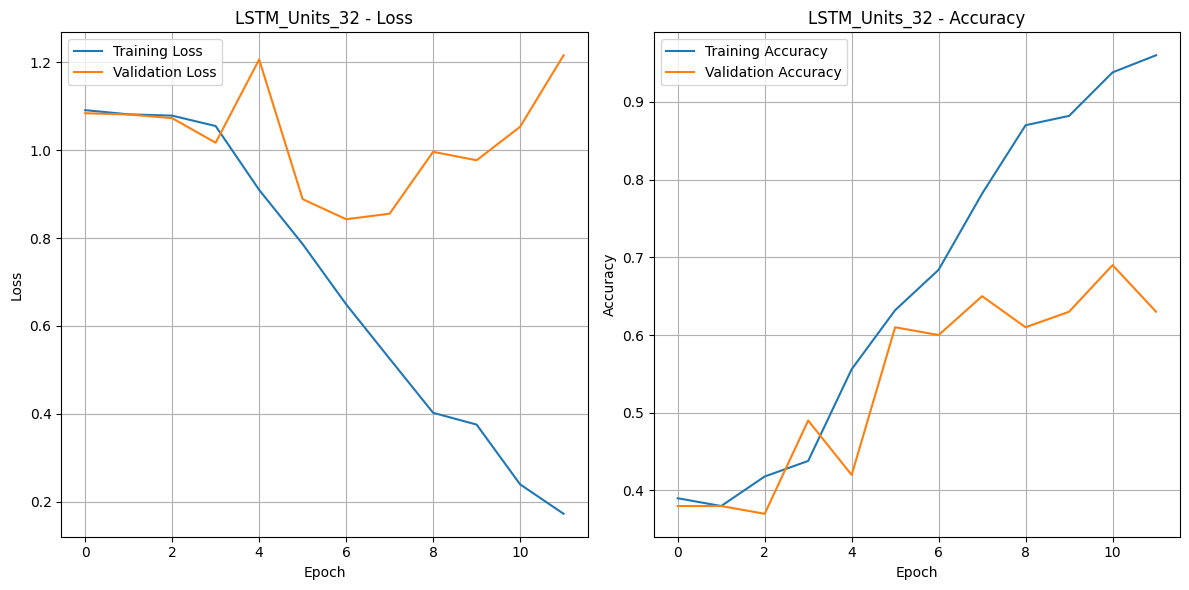

Best Keras model (full) saved to: ../bin/lstm_models\LSTM_Units_32_best.h5
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 203ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Macro F1-score on Validation set: 0.6285
Macro F1-score on Test set: 0.6851

--- Training Model: LSTM_Units_64 ---


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization_2            │ (None, 54)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_4 (Embedding)         │ (None, 54, 64)         │       181,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ (None, 54, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 54, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 247,811 (968.01 KB)

 Trainable params: 247,811 (968.01 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.3462 - loss: 1.0996

16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 133ms/step - accuracy: 0.3476 - loss: 1.0992 - val_accuracy: 0.3800 - val_loss: 1.0840
Epoch 2/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.3686 - loss: 1.0838

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - accuracy: 0.3707 - loss: 1.0837 - val_accuracy: 0.3800 - val_loss: 1.0750
Epoch 3/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.4571 - loss: 1.0408

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - accuracy: 0.4589 - loss: 1.0379 - val_accuracy: 0.5200 - val_loss: 0.9899
Epoch 4/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.6029 - loss: 0.8538

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - accuracy: 0.6053 - loss: 0.8502 - val_accuracy: 0.6100 - val_loss: 0.8745
Epoch 5/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 0.7125 - loss: 0.6640 - val_accuracy: 0.6300 - val_loss: 0.9144
Epoch 6/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 0.6614 - loss: 0.5793 - val_accuracy: 0.6200 - val_loss: 1.0357
Epoch 7/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 0.7250 - loss: 0.5949 - val_accuracy: 0.6100 - val_loss: 1.0798
Epoch 8/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 0.7433 - loss: 0.5412 - val_accuracy: 0.6400 - val_loss: 0.9732
Epoch 9/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 0.7222 - loss: 0.5650 - val_accuracy: 0.6100 - val_loss: 1.0229


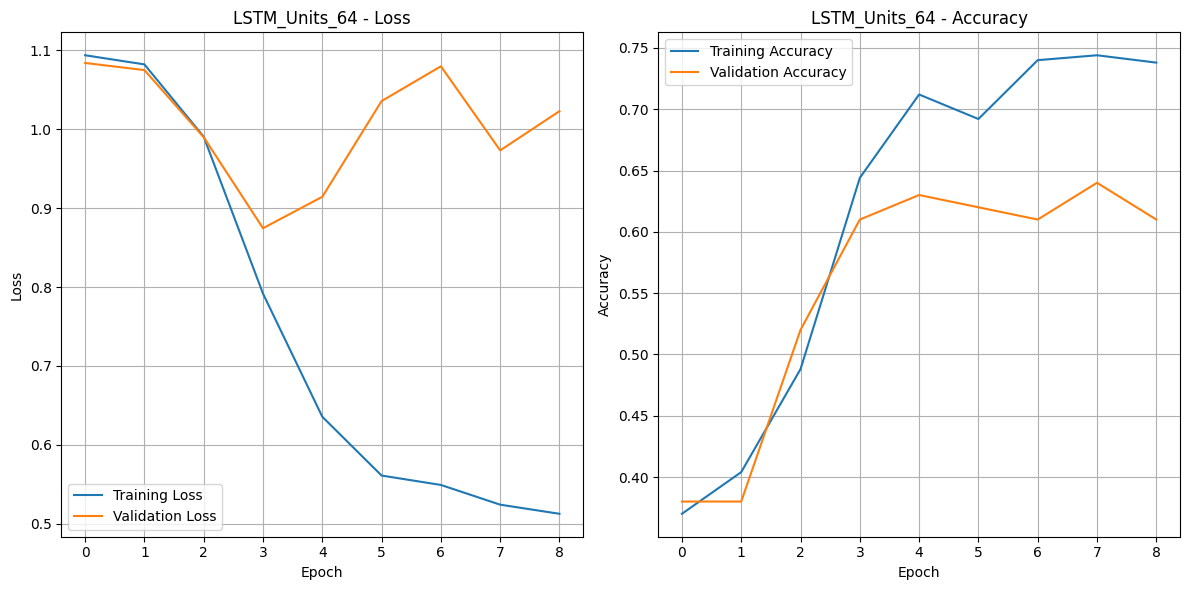

Best Keras model (full) saved to: ../bin/lstm_models\LSTM_Units_64_best.h5
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 213ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Macro F1-score on Validation set: 0.4666
Macro F1-score on Test set: 0.4894

--- Training Model: LSTM_Units_128 ---


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization_2            │ (None, 54)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_5 (Embedding)         │ (None, 54, 64)         │       181,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_10 (LSTM)                  │ (None, 54, 128)        │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 54, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 412,355 (1.57 MB)

 Trainable params: 412,355 (1.57 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.3203 - loss: 1.0925

16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 172ms/step - accuracy: 0.3225 - loss: 1.0926 - val_accuracy: 0.5000 - val_loss: 1.0786
Epoch 2/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.4356 - loss: 1.0434

16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 0.4389 - loss: 1.0404 - val_accuracy: 0.4900 - val_loss: 0.9857
Epoch 3/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.5621 - loss: 0.8472

16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 0.5635 - loss: 0.8462 - val_accuracy: 0.5600 - val_loss: 0.8675
Epoch 4/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step - accuracy: 0.6353 - loss: 0.7066 - val_accuracy: 0.6000 - val_loss: 1.0141
Epoch 5/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.7101 - loss: 0.6294

16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step - accuracy: 0.7100 - loss: 0.6293 - val_accuracy: 0.5800 - val_loss: 0.8403
Epoch 6/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - accuracy: 0.6902 - loss: 0.5655 - val_accuracy: 0.6200 - val_loss: 1.0148
Epoch 7/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 109ms/step - accuracy: 0.7349 - loss: 0.5016 - val_accuracy: 0.5800 - val_loss: 1.0665
Epoch 8/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step - accuracy: 0.7156 - loss: 0.5102 - val_accuracy: 0.6200 - val_loss: 1.0832
Epoch 9/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step - accuracy: 0.7327 - loss: 0.4783 - val_accuracy: 0.5100 - val_loss: 1.0270
Epoch 10/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step - accuracy: 0.7844 - loss: 0.4533 - val_accuracy: 0.5600 - val_loss: 1.0984


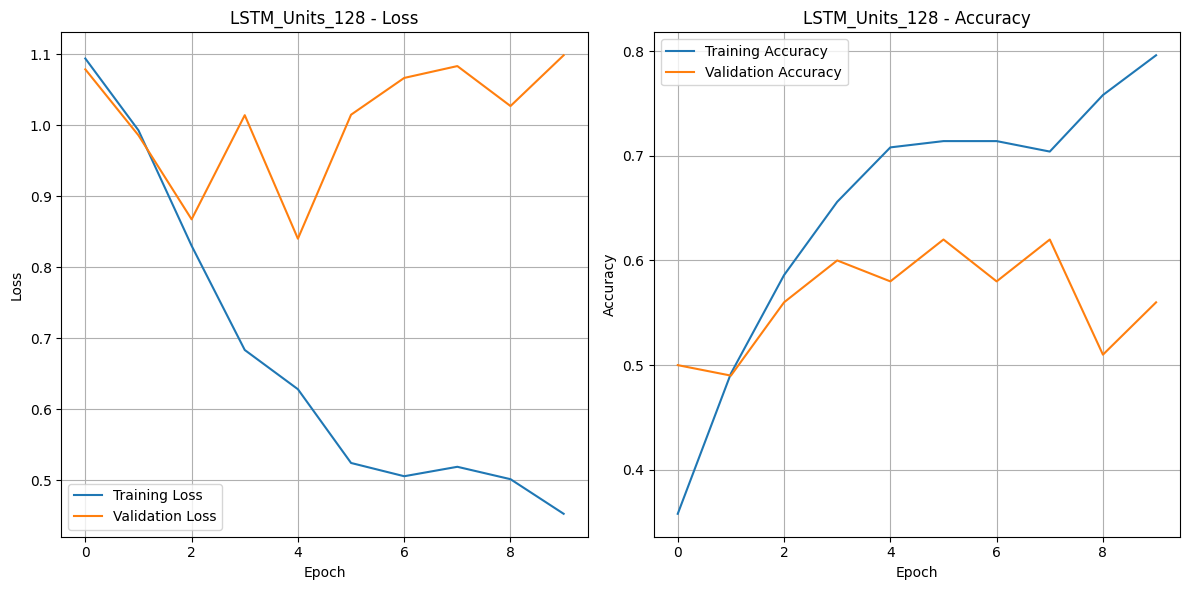

Best Keras model (full) saved to: ../bin/lstm_models\LSTM_Units_128_best.h5
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 223ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step
Macro F1-score on Validation set: 0.5574
Macro F1-score on Test set: 0.6315

--- Summary: Pengaruh banyak cell LSTM per layer ---
LSTM_Units_32: Validation Macro F1 = 0.6285, Test Macro F1 = 0.6851
LSTM_Units_64: Validation Macro F1 = 0.4666, Test Macro F1 = 0.4894
LSTM_Units_128: Validation Macro F1 = 0.5574, Test Macro F1 = 0.6315


In [15]:
lstm_units_variations = [32, 64, 128]

results_units = {}

for units in lstm_units_variations:
    model_params = {
        'num_lstm_layers': 2,
        'lstm_units': units,
        'lstm_direction': 'unidirectional'
    }
    model_name = f"LSTM_Units_{units}"

    history, y_val_pred, y_test_pred = train_and_evaluate_model(
        model_name,
        model_params,
        x_train, y_train, x_val, y_val,
        epochs=15
    )

    val_macro_f1 = evaluate_macro_f1(y_val, y_val_pred, "Validation")
    test_macro_f1 = evaluate_macro_f1(y_test, y_test_pred, "Test")

    results_units[model_name] = {
        'val_macro_f1': val_macro_f1,
        'test_macro_f1': test_macro_f1,
        'history': history
    }

print("\n--- Summary: Pengaruh banyak cell LSTM per layer ---")
for name, res in results_units.items():
    print(f"{name}: Validation Macro F1 = {res['val_macro_f1']:.4f}, Test Macro F1 = {res['test_macro_f1']:.4f}")

### Variation in LSTM Layer Direction


--- Training Model: LSTM_Direction_unidirectional ---


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization_2            │ (None, 54)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_6 (Embedding)         │ (None, 54, 64)         │       181,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_12 (LSTM)                  │ (None, 54, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 54, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_13 (LSTM)                  │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 247,811 (968.01 KB)

 Trainable params: 247,811 (968.01 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.3802 - loss: 1.0920

16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - accuracy: 0.3798 - loss: 1.0918 - val_accuracy: 0.3800 - val_loss: 1.0749
Epoch 2/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.4389 - loss: 1.0577

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - accuracy: 0.4408 - loss: 1.0558 - val_accuracy: 0.5200 - val_loss: 0.9336
Epoch 3/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.5975 - loss: 0.7972

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - accuracy: 0.5978 - loss: 0.7980 - val_accuracy: 0.6000 - val_loss: 0.8316
Epoch 4/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - accuracy: 0.6770 - loss: 0.6352 - val_accuracy: 0.5800 - val_loss: 1.0986
Epoch 5/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 0.7195 - loss: 0.5381 - val_accuracy: 0.5200 - val_loss: 0.9417
Epoch 6/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - accuracy: 0.7159 - loss: 0.5176 - val_accuracy: 0.5900 - val_loss: 1.0818
Epoch 7/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 0.8488 - loss: 0.4225 - val_accuracy: 0.4900 - val_loss: 1.1158
Epoch 8/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 0.7401 - loss: 0.4838 - val_accuracy: 0.5900 - val_loss: 1.1624


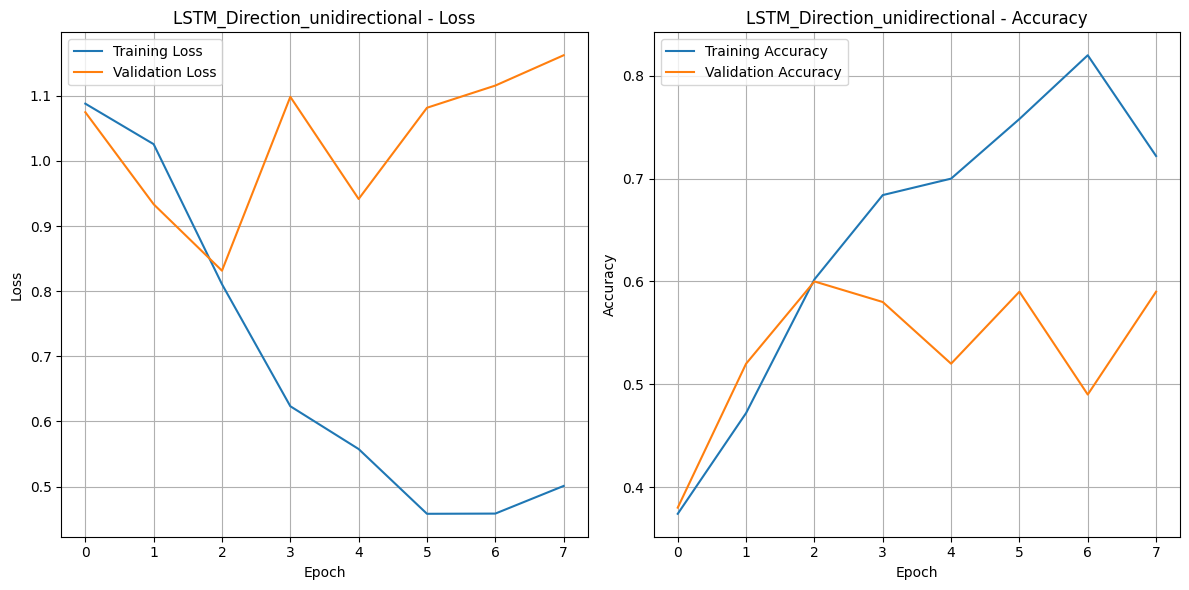

Best Keras model (full) saved to: ../bin/lstm_models\LSTM_Direction_unidirectional_best.h5
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 232ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Macro F1-score on Validation set: 0.4551
Macro F1-score on Test set: 0.4949

--- Training Model: LSTM_Direction_bidirectional ---


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization_2            │ (None, 54)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_7 (Embedding)         │ (None, 54, 64)         │       181,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 54, 128)        │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 54, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 346,819 (1.32 MB)

 Trainable params: 346,819 (1.32 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.3711 - loss: 1.0865

16/16 ━━━━━━━━━━━━━━━━━━━━ 13s 174ms/step - accuracy: 0.3726 - loss: 1.0861 - val_accuracy: 0.5500 - val_loss: 1.0285
Epoch 2/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.6047 - loss: 0.9457

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - accuracy: 0.6029 - loss: 0.9453 - val_accuracy: 0.5600 - val_loss: 0.9002
Epoch 3/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.6114 - loss: 0.7779

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - accuracy: 0.6136 - loss: 0.7746 - val_accuracy: 0.6600 - val_loss: 0.7546
Epoch 4/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - accuracy: 0.8526 - loss: 0.4364 - val_accuracy: 0.6200 - val_loss: 0.8437
Epoch 5/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - accuracy: 0.8677 - loss: 0.3279 - val_accuracy: 0.6900 - val_loss: 0.8489
Epoch 6/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9184 - loss: 0.2243

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - accuracy: 0.9200 - loss: 0.2226 - val_accuracy: 0.7600 - val_loss: 0.7284
Epoch 7/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - accuracy: 0.9853 - loss: 0.0919 - val_accuracy: 0.7600 - val_loss: 0.8423
Epoch 8/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - accuracy: 0.9898 - loss: 0.0432 - val_accuracy: 0.7700 - val_loss: 0.8827
Epoch 9/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - accuracy: 0.9980 - loss: 0.0165 - val_accuracy: 0.7200 - val_loss: 1.2208
Epoch 10/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - accuracy: 0.9941 - loss: 0.0323 - val_accuracy: 0.7300 - val_loss: 1.1997
Epoch 11/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - accuracy: 0.9934 - loss: 0.0286 - val_accuracy: 0.7500 - val_loss: 1.0652


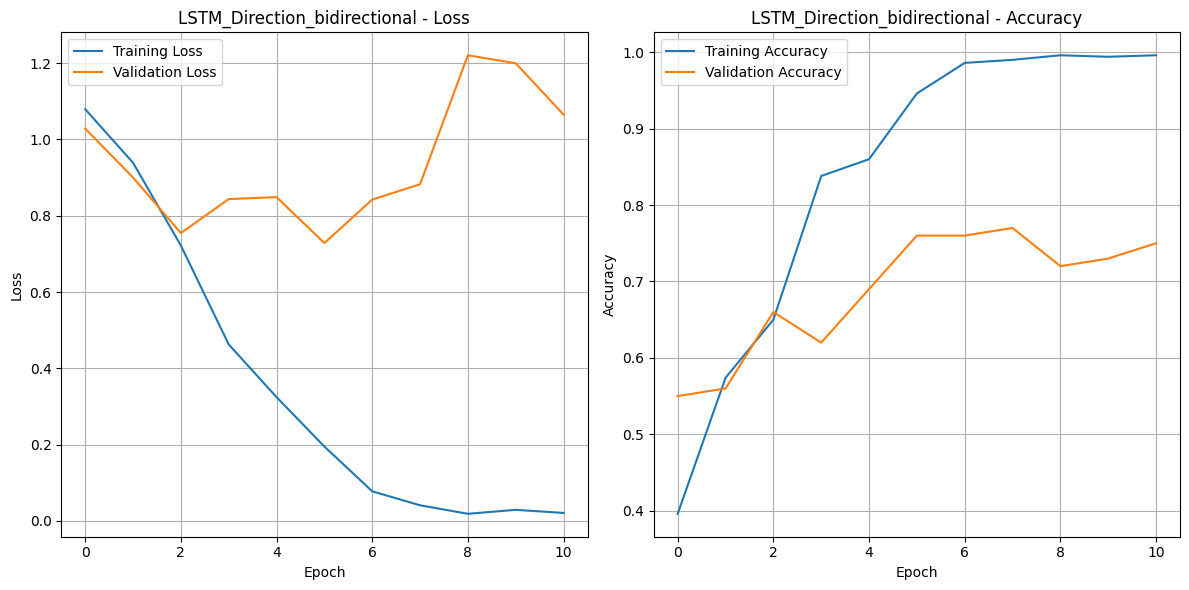

Best Keras model (full) saved to: ../bin/lstm_models\LSTM_Direction_bidirectional_best.h5
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 378ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Macro F1-score on Validation set: 0.7427
Macro F1-score on Test set: 0.6850

--- Summary: Pengaruh jenis layer LSTM berdasarkan arah ---
LSTM_Direction_unidirectional: Validation Macro F1 = 0.4551, Test Macro F1 = 0.4949
LSTM_Direction_bidirectional: Validation Macro F1 = 0.7427, Test Macro F1 = 0.6850


In [16]:
lstm_direction_variations = ['unidirectional', 'bidirectional']

results_direction = {}

for direction in lstm_direction_variations:
    model_params = {
        'num_lstm_layers': 2,
        'lstm_units': 64,
        'lstm_direction': direction
    }
    model_name = f"LSTM_Direction_{direction}"

    history, y_val_pred, y_test_pred = train_and_evaluate_model(
        model_name,
        model_params,
        x_train, y_train, x_val, y_val,
        epochs=15
    )

    val_macro_f1 = evaluate_macro_f1(y_val, y_val_pred, "Validation")
    test_macro_f1 = evaluate_macro_f1(y_test, y_test_pred, "Test")

    results_direction[model_name] = {
        'val_macro_f1': val_macro_f1,
        'test_macro_f1': test_macro_f1,
        'history': history
    }

print("\n--- Summary: Pengaruh jenis layer LSTM berdasarkan arah ---")
for name, res in results_direction.items():
    print(f"{name}: Validation Macro F1 = {res['val_macro_f1']:.4f}, Test Macro F1 = {res['test_macro_f1']:.4f}")

### Overall Analysis and Conclusions

In [17]:
# Helper function to print conclusions clearly
def print_conclusion(experiment_name, results_dict):
    print(f"\n--- {experiment_name} ---")
    best_val_f1 = -1
    best_model_name = ""
    for name, res in results_dict.items():
        print(f"{name}: Val Macro F1 = {res['val_macro_f1']:.4f}, Test Macro F1 = {res['test_macro_f1']:.4f}")
        if res['val_macro_f1'] > best_val_f1:
            best_val_f1 = res['val_macro_f1']
            best_model_name = name
    print(f"Best performing model in this experiment (based on Validation F1): {best_model_name} (F1: {best_val_f1:.4f})")

print_conclusion("Pengaruh jumlah layer LSTM", results_layer_count)
print_conclusion("Pengaruh banyak cell LSTM per layer", results_units)
print_conclusion("Pengaruh jenis layer LSTM berdasarkan arah", results_direction)


--- Pengaruh jumlah layer LSTM ---
LSTM_Layers_1: Val Macro F1 = 0.4472, Test Macro F1 = 0.4881
LSTM_Layers_2: Val Macro F1 = 0.6939, Test Macro F1 = 0.6437
LSTM_Layers_3: Val Macro F1 = 0.6346, Test Macro F1 = 0.6691
Best performing model in this experiment (based on Validation F1): LSTM_Layers_2 (F1: 0.6939)

--- Pengaruh banyak cell LSTM per layer ---
LSTM_Units_32: Val Macro F1 = 0.6285, Test Macro F1 = 0.6851
LSTM_Units_64: Val Macro F1 = 0.4666, Test Macro F1 = 0.4894
LSTM_Units_128: Val Macro F1 = 0.5574, Test Macro F1 = 0.6315
Best performing model in this experiment (based on Validation F1): LSTM_Units_32 (F1: 0.6285)

--- Pengaruh jenis layer LSTM berdasarkan arah ---
LSTM_Direction_unidirectional: Val Macro F1 = 0.4551, Test Macro F1 = 0.4949
LSTM_Direction_bidirectional: Val Macro F1 = 0.7427, Test Macro F1 = 0.6850
Best performing model in this experiment (based on Validation F1): LSTM_Direction_bidirectional (F1: 0.7427)


## Forward Pass Comparison

In [18]:
model_filepath_to_load = f"{MODEL_SAVE_DIR}/LSTM_Direction_bidirectional_best.h5"

In [29]:
from sequential import Sequential
from layers.text_vectorization import TextVectorizationWrapper
from layers.embedding import Embedding
from layers.dense import Dense
from layers.dropout import Dropout
from layers.lstm import LSTM
from layers.bidirectional import Bidirectional

custom_lstm = Sequential([
    TextVectorizationWrapper(TextVectorizer=text_vectorization_layer),
    Embedding(
        input_dim=MAX_TOKENS,
        output_dim=EMBEDDING_DIM,
    ),
    Bidirectional(LSTM(units=64, return_sequences=True)),
    Dropout(),
    Bidirectional(LSTM(units=64)),
    Dropout(),
    Dense(3,activation="softmax")
])

In [30]:
custom_lstm.load_weights(model_filepath_to_load)

HDF5 layer keys: ['bidirectional', 'bidirectional_1', 'dense_7', 'dropout_14', 'dropout_15', 'embedding_7', 'text_vectorization_2', 'top_level_model_weights']
Custom layer 0 (type: TextVectorizationWrapper) has no 'key' attribute, skipping.
Loading 1 weight array(s) into layer 1 (type: Embedding, key: embedding_7)
Loading 6 weight array(s) into layer 2 (type: Bidirectional, key: bidirectional)
Loading 0 weight array(s) into layer 3 (type: Dropout, key: dropout_14)
Dropout has no trainable weights — skipping
Loading 6 weight array(s) into layer 4 (type: Bidirectional, key: bidirectional_1)
Loading 0 weight array(s) into layer 5 (type: Dropout, key: dropout_15)
Dropout has no trainable weights — skipping
Loading 2 weight array(s) into layer 6 (type: Dense, key: dense_7)


In [31]:
keras_model = tf.keras.models.load_model(model_filepath_to_load)
keras_model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization_2            │ (None, 54)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_7 (Embedding)         │ (None, 54, 64)         │       181,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 54, 128)        │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 54, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 346,821 (1.32 MB)

 Trainable params: 346,819 (1.32 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

In [32]:
text_vectorization_layer_loaded = None
for layer in keras_model.layers:
    if isinstance(layer, tf.keras.layers.TextVectorization):
        text_vectorization_layer_loaded = layer
        break

if text_vectorization_layer_loaded:
    print(f"Found TextVectorization layer: {text_vectorization_layer_loaded.name}")
    print("Re-adapting the TextVectorization layer...")
    text_vectorization_layer_loaded.adapt(x_train)
    print("TextVectorization layer re-adapted.")
else:
    print("ERROR: TextVectorization layer not found in the loaded model.")

Found TextVectorization layer: text_vectorization_2
Re-adapting the TextVectorization layer...
TextVectorization layer re-adapted.


In [35]:
keras_model.predict(x_test)
y_test_pred_probs = keras_model.predict(x_test)
print(y_test_pred_probs[:5])
y_test_pred_classes = np.argmax(y_test_pred_probs, axis=1)
print(y_test_pred_classes[:5])

evaluate_macro_f1(y_test, y_test_pred_classes, "Keras Model Test")

13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
[[0.0127591  0.0124714  0.9747695 ]
 [0.1607495  0.8041497  0.03510086]
 [0.6497885  0.31009784 0.04011373]
 [0.00443434 0.00430323 0.99126244]
 [0.11669163 0.8027135  0.08059493]]
[2 1 0 2 1]
Macro F1-score on Keras Model Test set: 0.6879


0.6879223884973619

In [34]:
# 1. Perform prediction with your custom model
print("\n--- Predicting with Custom Sequential Model ---")
custom_model_pred_probs = custom_lstm.predict(x_test)
print(custom_model_pred_probs[:5])
custom_model_pred_classes = np.argmax(custom_model_pred_probs, axis=1)
print(custom_model_pred_classes[:50])

# 2. Calculate F1 score for your custom model
# You'll need an evaluation function, similar to what you used for the Keras model
# (Assuming you have an 'evaluate_macro_f1' function)
evaluate_macro_f1(y_test, custom_model_pred_classes, "Custom Model Test")


--- Predicting with Custom Sequential Model ---
[[0.18164613 0.56729602 0.25105785]
 [0.17289475 0.77734029 0.04976496]
 [0.27351095 0.65619388 0.07029517]
 [0.01415406 0.01391396 0.97193197]
 [0.11255906 0.78743511 0.10000583]]
[1 1 1 2 1 0 0 1 1 2 1 2 1 1 1 0 1 0 1 2 1 2 2 1 1 2 0 0 0 2 0 1 0 1 0 0 1
 0 2 2 2 0 1 0 1 1 1 1 1 1]
Macro F1-score on Custom Model Test set: 0.6177


0.617692162907859